In [7]:
!sudo apt-get install python3-mysqldb
!sudo pip3 install -U sqlalchemy sql_magic tqdm

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-mysqldb is already the newest version (1.3.10-1build1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Requirement already up-to-date: sqlalchemy in /usr/local/lib/python3.6/dist-packages (1.3.14)
Requirement already up-to-date: sql_magic in /usr/local/lib/python3.6/dist-packages (0.0.4)


In [1]:
import requests

In [2]:
# This gives information for each station that remains stable over time
url_stations = 'https://gbfs.citibikenyc.com/gbfs/en/station_information.json'

In [3]:
# This gives the live status of all the stations (e.g., bikes available etc)
url_status = 'https://gbfs.citibikenyc.com/gbfs/en/station_status.json'

In [4]:
# We fetch for now just the time-invariant data
results = requests.get(url_stations).json() 

In [5]:
# We only need a subset of the data in the JSON returned by the Citibike API, so we keep only what we need
stations = results["data"]["stations"]

In [6]:
# We will not be using dataframes for this insertion task. (See the A6 notebook if you want to use Pandas)
# We just put the data in a dataframe to understand what is going on.
import pandas as pd
df_stations = pd.DataFrame(stations)
df_stations.head(5)

,station_id,external_id,name,short_name,lat,lon,region_id,rental_methods,capacity,rental_url,electric_bike_surcharge_waiver,eightd_has_key_dispenser,eightd_station_services,has_kiosk
0,304,66db6da2-0aca-11e7-82f6-3863bb44ef7c,Broadway & Battery Pl,4962.01,40.704633,-74.013617,71,"[CREDITCARD, KEY]",33,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,True,[{'id': 'a58d9e34-2f28-40eb-b4a6-c8c01375657a'...,True
1,359,66dbc982-0aca-11e7-82f6-3863bb44ef7c,E 47 St & Park Ave,6584.12,40.755103,-73.974987,71,"[CREDITCARD, KEY]",64,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,False,[{'id': '2e104e31-606a-44af-8b25-ceaffc338489'...,True
2,367,66dbcdfc-0aca-11e7-82f6-3863bb44ef7c,E 53 St & Lexington Ave,6617.09,40.758281,-73.970694,71,"[CREDITCARD, KEY]",34,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,False,[{'id': '2d9a5c9e-50e0-4aed-a63b-91ca81e7d2c0'...,True
3,402,66dbf0d0-0aca-11e7-82f6-3863bb44ef7c,Broadway & E 22 St,6098.07,40.740343,-73.989551,71,"[CREDITCARD, KEY]",39,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,False,[{'id': '37a1ae1b-3dd6-4876-8c57-572aaac97981'...,True
4,3443,66de8a86-0aca-11e7-82f6-3863bb44ef7c,W 52 St & 6 Ave,6740.01,40.761330,-73.979820,71,"[CREDITCARD, KEY]",41,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,False,False,[{'id': '286d75b2-088f-4a79-bf7d-223928be711c'...,True


In [8]:
import sqlalchemy
from sqlalchemy import create_engine

conn_string = 'mysql://{user}:{password}@{host}/'.format(
    host = 'db.ipeirotis.org', 
    user = 'student',
    password = 'dwdstudent2015')

engine = create_engine(conn_string)

db_name = 'public' 
create_db_query = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8'"

# Create a database
engine.execute(create_db_query)

# And lets switch to the database
engine.execute(f"USE {db_name}")

# To avoid conflicts between people writing in the same database, we add a random suffix in the tables
# We only create the variable once while running the notebook
import uuid
if 'suffix' not in globals():
    suffix = str(uuid.uuid4())[:8]
print(suffix)

68008965


In [9]:
# Create the two tables. One for storing the time-invariant station data
# and another table to store the time-varying station status data
stations_table = f'Stations_{suffix}'

sql = f'''CREATE TABLE IF NOT EXISTS {stations_table}
                                (station_id int, 
                                name varchar(250), 
                                capacity int,
                                lat float,
                                lon float,
                                region_id int,
                                short_name varchar(250),
                                rental_url varchar(250),
                                eightd_has_key_dispenser bool,
                                PRIMARY KEY(station_id)
                 )'''
engine.execute(sql)

In [10]:
# Create the time-varying table
status_table = f'Status_{suffix}'
sql = f'''CREATE TABLE IF NOT EXISTS {status_table}
                                (station_id int, 
                                last_reported datetime,
                                num_bikes_available int,
                                num_ebikes_available int,
                                num_bikes_disabled int,
                                num_docks_available int,
                                num_docks_disabled int,
                                is_installed bool,
                                is_renting bool,
                                is_returning bool,
                                PRIMARY KEY(station_id, last_reported)
                                )'''
engine.execute(sql)

In [11]:
stations[0]

{'station_id': '304',
 'external_id': '66db6da2-0aca-11e7-82f6-3863bb44ef7c',
 'name': 'Broadway & Battery Pl',
 'short_name': '4962.01',
 'lat': 40.70463334,
 'lon': -74.01361706,
 'region_id': 71,
 'rental_methods': ['CREDITCARD', 'KEY'],
 'capacity': 33,
 'rental_url': 'http://app.citibikenyc.com/S6Lr/IBV092JufD?station_id=304',
 'electric_bike_surcharge_waiver': False,
 'eightd_has_key_dispenser': True,
 'eightd_station_services': [{'id': 'a58d9e34-2f28-40eb-b4a6-c8c01375657a',
   'service_type': 'ATTENDED_SERVICE',
   'bikes_availability': 'UNLIMITED',
   'docks_availability': 'NONE',
   'name': 'Valet Service',
   'description': 'Citi Bike Valet Attendant Service Available',
   'schedule_description': '',
   'link_for_more_info': 'https://www.citibikenyc.com/valet'}],
 'has_kiosk': True}

In [12]:
# We fetch for now just the time-invariant data
# Notice that we have the INSERT IGNORE so that even when we add the same entry
# again, we do not get an error that the line exists. We do get warnings
# but this is expected

from sqlalchemy.sql import text
from tqdm.autonotebook import tqdm

query_template = text(
    f'''INSERT IGNORE INTO {db_name}.{stations_table}
            (station_id, name, capacity, lat, lon,
            region_id, short_name, rental_url, eightd_has_key_dispenser) 
        VALUES (:station_id, :name, :capacity, :lat, :lon, :region_id, 
                    :short_name, :rental_url, :eightd_has_key_dispenser)''')

# The tqdm(stations) shows a progress bar
for entry in tqdm(stations):

    query_parameters = {
        "station_id": int(entry['station_id']),
        "name": entry.get('name'),
        "capacity": entry.get('capacity'),
        "lat": entry.get('lat'),
        "lon": entry.get('lon'),
        "region_id": entry.get('region_id'),
        "short_name": entry.get('short_name'),
        "rental_url": entry.get('rental_url'),
        "eightd_has_key_dispenser": entry.get('eightd_has_key_dispenser')
    }

    engine.execute(query_template, **query_parameters)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [13]:
check = pd.read_sql(f"SELECT * FROM {db_name}.{stations_table}", con=engine)
check

,station_id,name,capacity,lat,lon,region_id,short_name,rental_url,eightd_has_key_dispenser
0,72,W 52 St & 11 Ave,55,40.7673,-73.9939,71,6926.01,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
1,79,Franklin St & W Broadway,33,40.7191,-74.0067,71,5430.08,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
2,82,St James Pl & Pearl St,27,40.7112,-74.0002,71,5167.06,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
3,83,Atlantic Ave & Fort Greene Pl,62,40.6838,-73.9763,71,4354.07,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
4,116,W 17 St & 8 Ave,50,40.7418,-74.0015,71,6148.02,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
...,...,...,...,...,...,...,...,...,...
930,3913,Sands St Gate,19,40.6996,-73.9798,71,4812.04,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
931,3914,West End Ave & W 78 St,39,40.7838,-73.9817,71,7340.07,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
932,3916,Pearl St & Peck Slip,45,40.7085,-74.0028,71,5096.11,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,1
933,3917,Willoughby St & Ashland Pl,31,40.6918,-73.9788,71,4587.02,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0


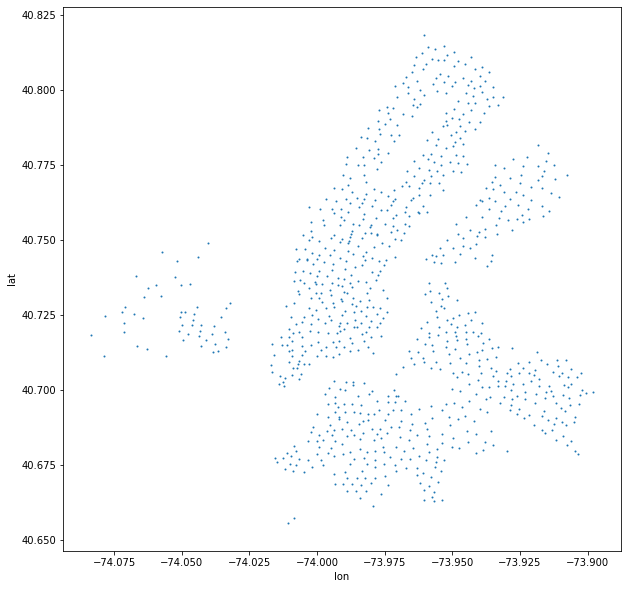

In [14]:
%matplotlib inline
check.plot(kind='scatter', x='lon', y='lat', s=1, figsize=(10,10))

In [15]:
results = requests.get(url_status).json() 
status = results["data"]["stations"]
status[0]

{'station_id': '304',
 'num_bikes_available': 5,
 'num_ebikes_available': 0,
 'num_bikes_disabled': 1,
 'num_docks_available': 27,
 'num_docks_disabled': 0,
 'is_installed': 1,
 'is_renting': 1,
 'is_returning': 0,
 'last_reported': 1583942048,
 'eightd_has_available_keys': True,
 'eightd_active_station_services': [{'id': 'a58d9e34-2f28-40eb-b4a6-c8c01375657a'}]}

In [16]:
# Now we fetch the data about the time varying elements of the citibike stations
from datetime import datetime

query_template = text(f'''INSERT IGNORE INTO {db_name}.{status_table}(station_id, 
                                            num_bikes_available,
                                            num_ebikes_available,
                                            num_bikes_disabled,
                                            num_docks_available,
                                            num_docks_disabled,
                                            is_installed,
                                            is_renting,
                                            is_returning,
                                            last_reported) 
                    VALUES (:station_id, :num_bikes_available, :num_ebikes_available, :num_bikes_disabled,
                    :num_docks_available, :num_docks_disabled, :is_installed, :is_renting, :is_returning, :last_reported)''')

for entry in tqdm(status):
    query_parameters = {
        "station_id" : int(entry['station_id']),
        "num_bikes_available" :  entry['num_bikes_available'],
        "num_bikes_disabled" : entry['num_bikes_disabled'],
        "num_ebikes_available" : entry['num_ebikes_available'],
        "num_docks_available" : entry['num_docks_available'],
        "num_docks_disabled" : entry['num_docks_disabled'],
        "is_installed" : entry['is_installed'],
        "is_renting" : entry['is_renting'],
        "is_returning" : entry['is_returning'],
        "last_reported" : datetime.fromtimestamp(entry['last_reported']) 
    }

    engine.execute(query_template, **query_parameters)


In [17]:
check = pd.read_sql(f"SELECT * FROM {db_name}.{status_table}", con=engine)
check


,station_id,last_reported,num_bikes_available,num_ebikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning
0,72,2020-03-11 15:55:03,6,0,1,48,0,1,1,1
1,79,2020-03-11 15:12:23,32,0,1,0,0,1,1,1
2,82,2020-03-11 15:14:45,27,0,0,0,0,1,1,1
3,83,2020-03-11 15:40:34,34,0,0,28,0,1,1,1
4,116,2020-03-11 15:53:17,48,1,2,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
930,3913,2020-03-11 15:51:59,19,0,0,0,0,1,1,1
931,3914,2020-03-11 15:13:25,0,0,0,39,0,1,1,1
932,3916,2020-03-11 15:54:39,44,0,1,0,0,1,1,1
933,3917,2020-03-11 15:51:12,10,0,1,20,0,1,1,1


In [18]:
drop_table_query = f"DROP TABLE IF EXISTS {db_name}.{status_table}"
print(drop_table_query)
engine.execute(drop_table_query)

DROP TABLE IF EXISTS public.Status_68008965


In [19]:
drop_table_query = f"DROP TABLE IF EXISTS {db_name}.{stations_table}"
print(drop_table_query)
engine.execute(drop_table_query)

DROP TABLE IF EXISTS public.Stations_68008965
